In [2]:
from google.colab import drive
import json
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ECE324/ECE324 Project
import pandas as pd
import string
import re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1n2vGsCOPhE_6QOOxyZh4O8W37BWTgMRY/ECE324 Project


In [ ]:
# file = open('/content/drive/MyDrive/ECE324/ECE324 Project/JSON Files/totalRawData.json') 
file = file = open('/content/drive/MyDrive/ECE324/ECE324 Project/JSON Files/totalRawData.json') 
raw = json.load(file) # raw is ALL the raw data to be cleaned
print(raw) 
file.close()

{'2. Sophie’s': ['Toronto', 'Breakfast & Brunch$$Mount Pleasant and Davisville', 'Open until 3:00 PM', 'Live wait time: 36 - 51 mins', "“A small place for breakfast and brunch. Pretty busy and can be line up for 30 to 45mins. But it's worth to wait. Fresh ingredients and cooked just right. I…” more", 'Outdoor seating', 'Delivery', 'Takeout', 'Join the Waitlist', '4 star rating'], '3. Pai Northern Thai Kitchen': ['Toronto', 'ThaiYonge and Eglinton', 'Open until 10:00 PM', "“Whoa, this is one of the better Thai establishments I've been to in a long time. Which says a lot, since there's so many good Thai restaurants. The food is a…” more", 'Delivery', 'Takeout', '4 star rating'], '4. Mary Be Kitchen': ['Toronto', 'Canadian (New)$$Yonge and St. Clair', 'Open until 9:00 PM', '“What a lovely place! Came here for brunch with my friends, and I absolutely adored it. The service is quick, the food is very affordable, and delicious! I…” more', 'Delivery', 'Takeout', '4.5 star rating'], '5. Liu': 

In [ ]:
def one_hot(cuisine, a):
  # cuisine is a set of all cuisines 
  # a is a string with the cuisines of this restaurant
  # return one cuisine  
  cuisine_list = list(cuisine)
  answer = [0] * len(cuisine_list)
  for i in range(len(cuisine_list)):
    if cuisine_list[i] in a:
      answer[i] = 1
  return answer.index(1)

In [ ]:
cuisine = set()
# removing number from front of keys
d = {}
for key in raw:
  # key
  k = key.split(' ')
  k = ''.join(k[1:]) # re-enter this as the new key
  raw_values = raw[key]
  
  # stars 
  clean_values = {'stars': raw_values[-1].split(' ')[0], 'delivery': 0, 'takeout': 0, 'Outdoor seating': 0}
  
  # hours
  hours_map = {"Midnight": 0, "12:00": 0, "Noon": 12, "12:30": 0.5, "1:00": 1, 
               "1:30": 1.5, "2:00": 2, "2:30": 2.5, "3:00": 3, "3:30": 3.5, 
               "4:00": 4, "4:30": 4.5, "5:00": 5, "5:30": 5.5, "6:00": 6,
               "6:30": 6.5, "7:00": 4, "7:30": 7.5, "8:00": 8, "8:30": 8.5,
               "9:00": 9, "9:30": 9.5, "10:00": 10, "10:30": 10.5, 
               "11:00": 11, "11:30": 2.5}
  if "Open until" in raw_values[2]:
    for key in hours_map:
      if key in raw_values[2]:
        if "PM" in raw_values[2]:
          clean_values['hours'] = hours_map[key] + 12
        else:
          clean_values['hours'] = hours_map[key]
  else:
    # assume it closes at 6pm
    clean_values['hours'] = '18'

  # Delivery options
  if 'Delivery' in raw_values:
    clean_values['delivery'] = 1
    raw_values.remove('Delivery')

  # Takeout options
  if 'Takeout' in raw_values:
    clean_values['takeout'] = 1
    raw_values.remove('Takeout')

  # Outdoor seating options
  if 'Outdoor seating' in raw_values:
    clean_values['Outdoor seating'] = 1
    raw_values.remove('Outdoor seating')
  d[k] = clean_values

  # Cost
  cost = raw_values[1].count('$')
  if cost == 0:
    cost = 2 # give it an average value
  clean_values['cost'] = cost
  start_cost = raw_values[1].find('$')
  end_of_cost = raw_values[1].rfind("$")
  length = len(raw_values[1])
  
  
  # cuisine and location 
  if start_cost > -1 and end_of_cost < length - 1:
    # If first value came with cuisine, cost and location concatenated
    # ex. 'Thai$$Entertainment District'
    cuisine.update(re.findall('[A-Z][^A-Z]*', raw_values[1][:start_cost]))
    # clean_values['location'] = raw_values[1][end_of_cost+1:]
    clean_values['location'] = 'Toronto'
  elif end_of_cost == length - 1:
    # cuisine, cost 
    # Ex. 'Thai$$'
    cuisine.update(re.findall('[A-Z][^A-Z]*', raw_values[1][:start_cost]))
    
  elif len(re.findall(r'[A-Z]',raw_values[1])) < 2:
    # cuisine
    # ex. 'Thai'
    cuisine.update(re.findall('[A-Z][^A-Z]*', raw_values[1]))
    # clean_values['location'] = 'Toronto'
  else:
    # ex. 'ThaiMount Pleasant'
    s = raw_values[1].split(' ')
    for i in range(len(s)-1, -1, -1):
      if len(re.findall('[A-Z][^A-Z]*', s[i])) > 1:
        split = re.findall('[A-Z][^A-Z]*', s[i])
        cuisine.update(re.findall('[A-Z][^A-Z]*', ''.join(s[:i]) + split[0]))
        if len(s) > i:
          pass 
          # clean_values['location'] = split[1] + ''.join(s[i+1:])
        else:
          clean_values['location'] = split[1]
        break 
  # latitude, longitude
  location_map = {"Toronto": 0, "Mississauga": 1, "Vaughan": 2, "RichmondHill": 3, "Brampton": 4, "Markham": 5} 
  clean_values['location'] = location_map[raw_values[0]]
  if 'location' not in clean_values:
    clean_values['location'] = 0


for key in raw:
  k = key.split(' ')
  k = ''.join(k[1:]) 
  d[k]['cuisine'] = one_hot(cuisine, raw[key][1])

print(d)

{'Sophie’s': {'stars': '4', 'delivery': 0, 'takeout': 0, 'Outdoor seating': 0, 'hours': 15, 'cost': 2, 'location': 0, 'cuisine': 4}, 'PaiNorthernThaiKitchen': {'stars': '4.5', 'delivery': 0, 'takeout': 0, 'Outdoor seating': 0, 'hours': 22, 'cost': 2, 'location': 0, 'cuisine': 43}, 'MaryBeKitchen': {'stars': '4.5', 'delivery': 0, 'takeout': 0, 'Outdoor seating': 0, 'hours': 21, 'cost': 2, 'location': 0, 'cuisine': 152}, 'Liu': {'stars': '4.5', 'delivery': 0, 'takeout': 0, 'Outdoor seating': 0, 'hours': 16, 'cost': 2, 'location': 0, 'cuisine': 72}, 'OrettaMidtown': {'stars': '4', 'delivery': 0, 'takeout': 0, 'Outdoor seating': 0, 'hours': 14.5, 'cost': 2, 'location': 0, 'cuisine': 4}, 'PositanoRestaurant': {'stars': '4', 'delivery': 0, 'takeout': 0, 'Outdoor seating': 0, 'hours': '18', 'cost': 2, 'location': 0, 'cuisine': 105}, 'MegumiMazesoba': {'stars': '4.5', 'delivery': 0, 'takeout': 0, 'Outdoor seating': 0, 'hours': 21, 'cost': 2, 'location': 0, 'cuisine': 105}, 'Mayrik': {'stars': 

In [7]:
df = pd.DataFrame.from_dict(d)
df = df.transpose()
df

,stars,delivery,takeout,Outdoor seating,hours,cost,location,cuisine
Sophie’s,4,1,1,1,15,2,0,34
PaiNorthernThaiKitchen,4.5,1,1,1,22,2,0,60
MaryBeKitchen,4.5,1,1,0,21,2,0,62
Liu,4.5,0,0,0,16,2,0,43
OrettaMidtown,4,0,0,1,14.5,2,0,18
...,...,...,...,...,...,...,...,...
FiveGuys,3.5,1,1,1,22,2,2,3
KraveIndian,4,0,0,0,21.5,2,2,113
SzechuanSzechuan,3,0,0,0,23,2,2,165
BanhMiNhuLan,4,0,0,0,16,1,2,127


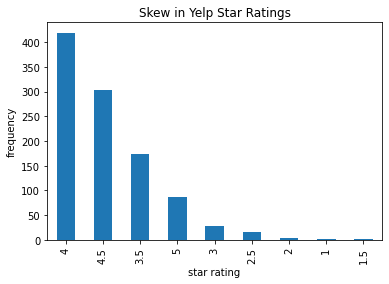

In [19]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax = df['stars'].value_counts().plot(kind="bar", legend=False)
plt.xlabel("star rating")
plt.ylabel("frequency")
plt.title("Skew in Yelp Star Ratings")
plt.show()

In [ ]:
df['hours'] = df['hours'].fillna(18)

In [ ]:
# Convert to csv file 
df.to_csv('cleanedData.csv', sep='\t', encoding='utf-8', index=False)
# test.to_csv('/content/drive/MyDrive/ECE324 Project/cleanedDatanew.csv', step=',', encoding='utf-8')